# **Forecast ML**

Autor: Sergio Diaz Paredes

Contacto:
- [Linkedin](https://www.linkedin.com/in/sergio-diaz-paredes/)
- [Github](https://github.com/SergioDP94)


# Caso:

Una tienda de productos tecnológicos necesita generar una proyección de demanda para cada uno de sus productos con el fin de optimizar el inventario y las estrategias de venta. Esto implica analizar datos históricos de ventas, incluyendo factores como las tendencias de compra, estacionalidad, promociones, precios y comportamientos de los consumidores. Utilizando estos datos, la tienda puede aplicar modelos de predicción (como regresión, series temporales o machine learning) para prever la demanda futura de cada producto. Con esta proyección, se pueden ajustar los niveles de inventario y mejorar la planificación de compras y marketing.

## Paquetes

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from prophet import Prophet

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Data

In [ ]:
link = "https://raw.githubusercontent.com/SergioDP94/Talleres/refs/heads/main/Forecast/ventas_tech2.csv"
data = pd.read_csv(link,parse_dates=['Fecha'])
data.head()

,Fecha,Producto,Medio_pago,Sucursal,Factura
0,2024-01-01,Laptops,PayPal,Sucursal Este,FAC000001
1,2024-01-01,Laptops,Billetera digital,Sucursal Centro,FAC000002
2,2024-01-01,Laptops,Billetera digital,Sucursal Centro,FAC000003
3,2024-01-01,Laptops,Efectivo,Sucursal Sur,FAC000004
4,2024-01-01,Laptops,Efectivo,Sucursal Este,FAC000005


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106652 entries, 0 to 106651
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Fecha       106652 non-null  datetime64[ns]
 1   Producto    106652 non-null  object        
 2   Medio_pago  106652 non-null  object        
 3   Sucursal    106652 non-null  object        
 4   Factura     106652 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 4.1+ MB


<Axes: xlabel='Fecha'>

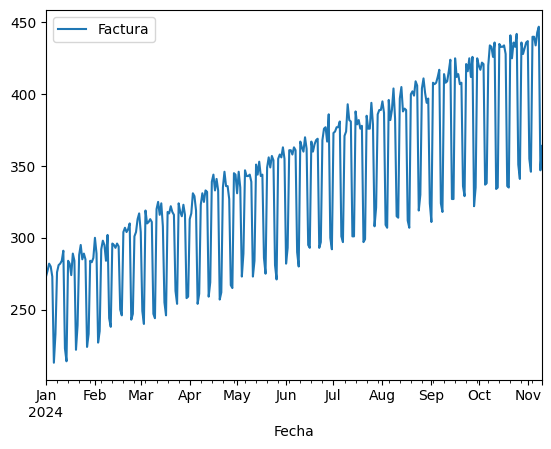

In [ ]:
data.pivot_table(index='Fecha',values='Factura',aggfunc='count').plot()

In [ ]:
data.pivot_table(index='Fecha',values='Factura',columns='Producto',aggfunc='count')

Producto,Auriculares_inalambricos,Camaras_digitales,Laptops,Reloj_inteligente,Tablets,Telefonos_inteligentes
Fecha,,,,,,
2024-01-01,79,19,51,31,28,65
2024-01-02,89,16,49,30,27,66
2024-01-03,84,22,52,31,29,64
2024-01-04,84,18,55,28,30,65
2024-01-05,82,18,49,30,30,64
...,...,...,...,...,...,...
2024-11-06,119,45,80,68,42,80
2024-11-07,126,43,85,63,47,79
2024-11-08,125,45,84,67,45,81


<Axes: xlabel='Fecha'>

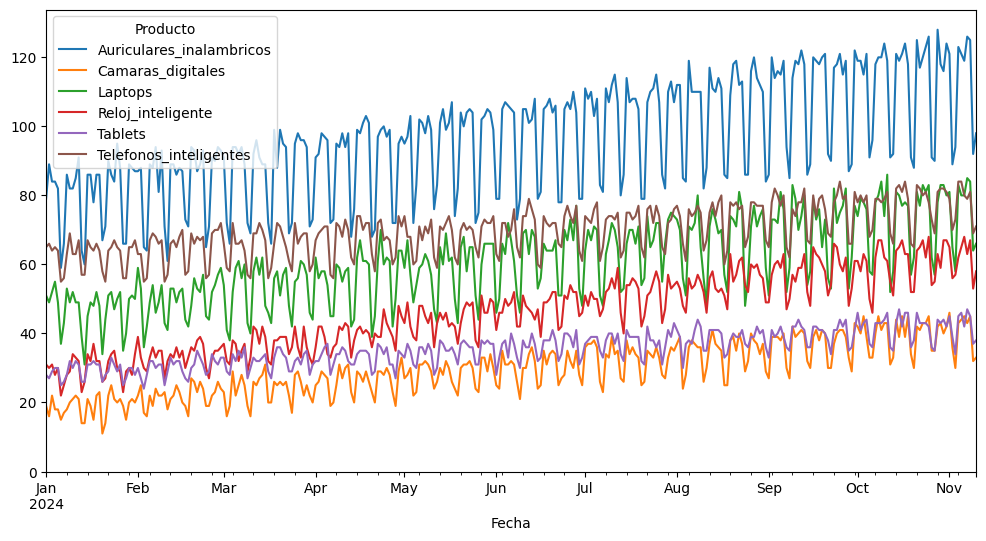

In [ ]:
tabla = data.pivot_table(index='Fecha',columns='Producto',values='Factura',aggfunc='count')
tabla.plot(ylim=(0),figsize=(12,6))

In [ ]:
name = 'Reloj_inteligente'
serie = tabla[name]
serie.tail()

,Reloj_inteligente
Fecha,
2024-11-06,68
2024-11-07,63
2024-11-08,67
2024-11-09,53
2024-11-10,58


## Automatizacion

In [ ]:
def get_forecast(serie,n_step,type='hw'):
  if type == 'hw':
    holt_winters_model = ExponentialSmoothing(serie, trend='add', seasonal='add', seasonal_periods=7)
    holt_winters_fit = holt_winters_model.fit()
    holt_winters_forecast = holt_winters_fit.forecast(steps=n_step)
    return holt_winters_forecast
  elif type == 'sarima':
    sarima_model = SARIMAX(serie, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    sarima_fit = sarima_model.fit()
    sarima_forecast = sarima_fit.forecast(steps=n_step)
    return sarima_forecast
  elif type == 'prophet':
    df = serie.reset_index()
    df.columns = ['ds', 'y']
    prophet_model = Prophet(
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    yearly_seasonality=False,
    weekly_seasonality=True)
    prophet_model.fit(df)
    future = prophet_model.make_future_dataframe(periods=n_step, freq='D')
    forecast = prophet_model.predict(future)
    index = pd.date_range(serie.index[-1], periods=(n_step + 1), freq='D')[1:]
    prohet_forecast = pd.Series(forecast.yhat[-n_step:].to_list(),index=index)
    return prohet_forecast

In [ ]:
n_step = 21

In [ ]:
forecast_hw = get_forecast(serie,n_step,type='hw')
forecast_sar = get_forecast(serie,n_step,type='sarima')
forecast_prop = get_forecast(serie,n_step,type='prophet')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4a1b3m2w/_9sfxkc0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4a1b3m2w/vpq9qdjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47473', 'data', 'file=/tmp/tmp4a1b3m2w/_9sfxkc0.json', 'init=/tmp/tmp4a1b3m2w/vpq9qdjr.json', 'output', 'file=/tmp/tmp4a1b3m2w/prophet_model_s95eavh/prophet_model-20250118002036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


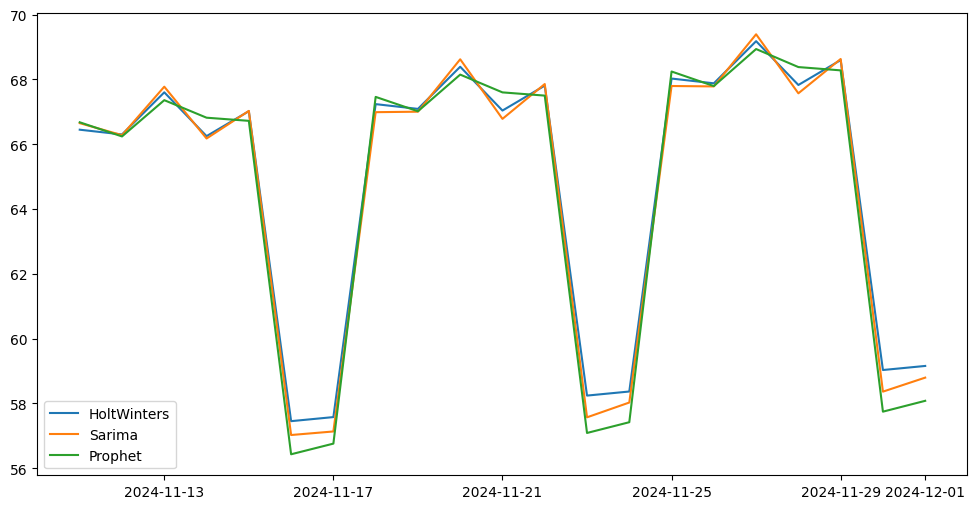

In [ ]:
fig, ax =plt.subplots(figsize=(12,6))
ax.plot(forecast_hw,label='HoltWinters')
ax.plot(forecast_sar,label='Sarima')
ax.plot(forecast_prop,label='Prophet')
#ax.plot(serie,label='Real')
ax.legend()
fig.show()

# Machine Learning

## Transformación de Series

<Axes: xlabel='Fecha'>

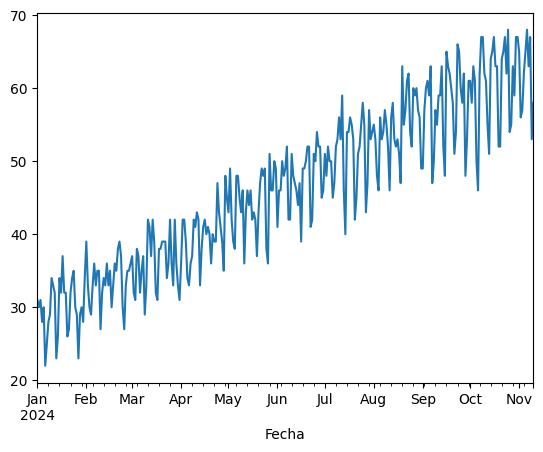

In [ ]:
serie.plot()

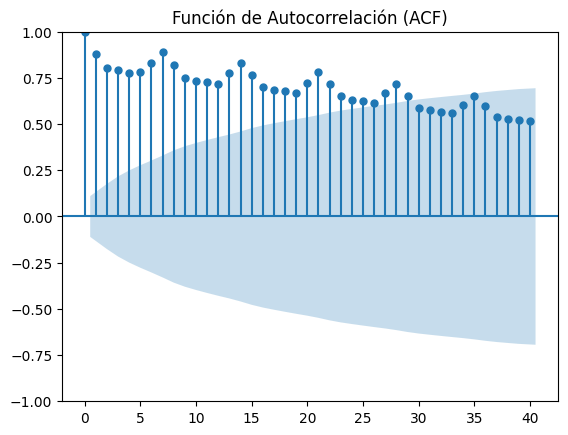

In [ ]:
# Gráfica de autocorrelación
plot_acf(serie, lags=40)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

<Axes: xlabel='Fecha'>

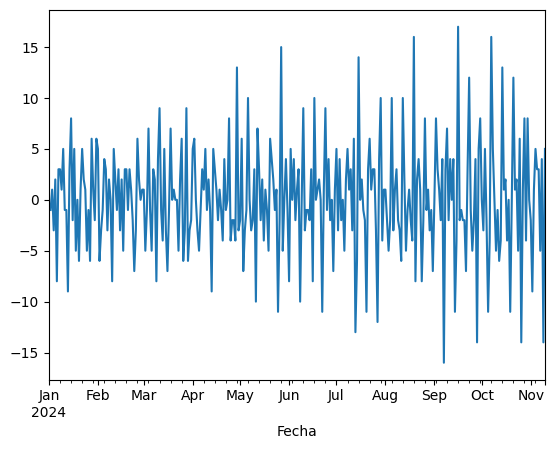

In [ ]:
serie.diff().plot()

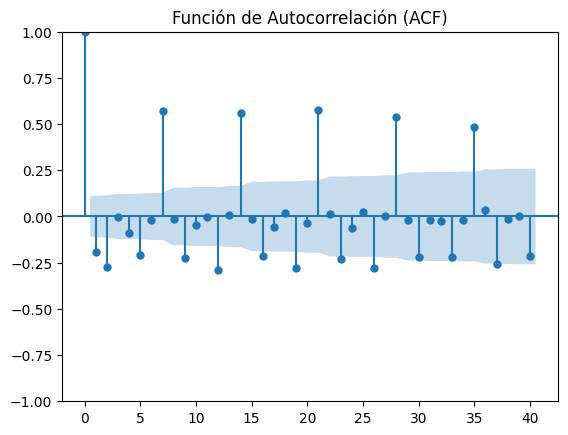

In [ ]:
# Gráfica de autocorrelación
plot_acf(serie.diff().dropna(), lags=40)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

<Axes: xlabel='Fecha'>

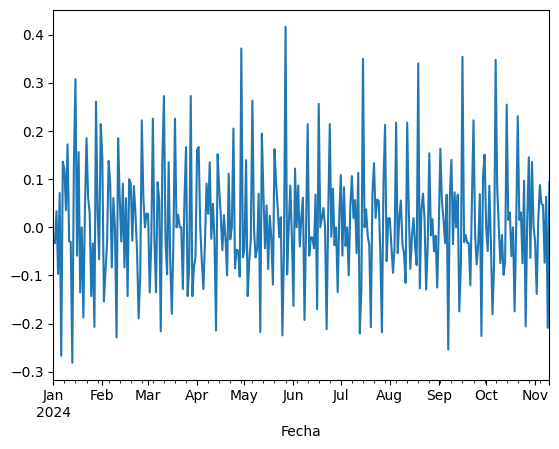

In [ ]:
serie.pct_change().plot()

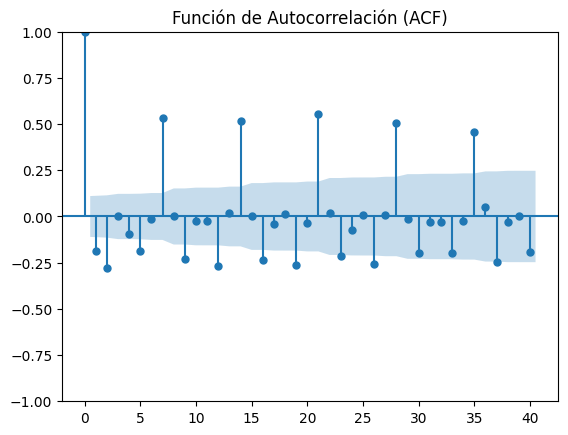

In [ ]:
# Gráfica de autocorrelación
plot_acf(serie.pct_change().dropna(), lags=40)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

<Axes: xlabel='Fecha'>

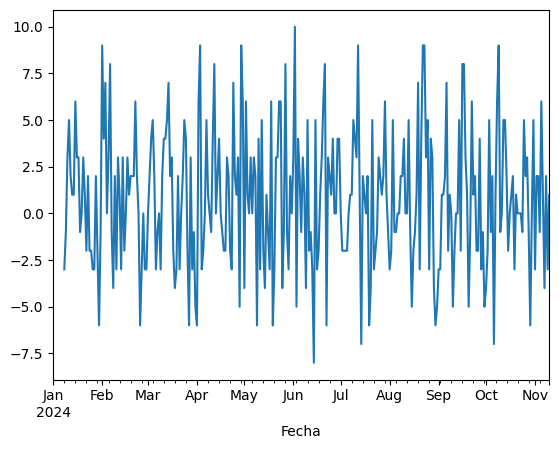

In [ ]:
serie.diff(7).plot()

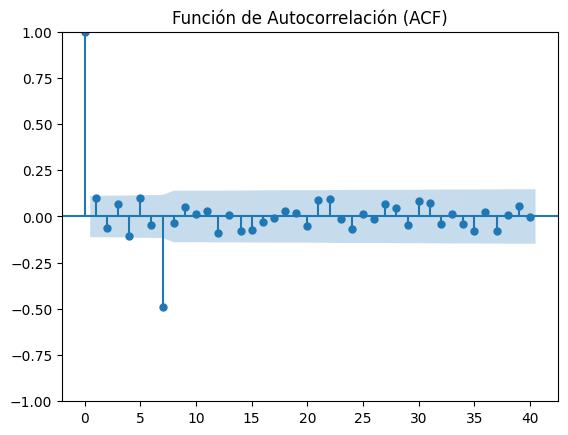

In [ ]:
# Gráfica de autocorrelación
plot_acf(serie.diff(7).dropna(), lags=40)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

<Axes: xlabel='Fecha'>

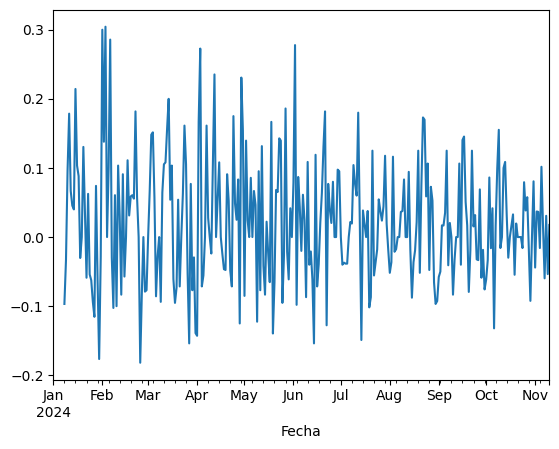

In [ ]:
serie.pct_change(7).plot()

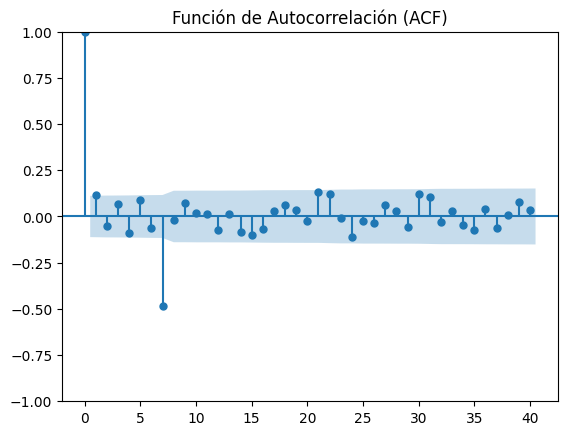

In [ ]:
# Gráfica de autocorrelación
plot_acf(serie.pct_change(7).dropna(), lags=40)
plt.title("Función de Autocorrelación (ACF)")
plt.show()

In [ ]:
serie.pct_change(7).reset_index()

,Fecha,Reloj_inteligente
0,2024-01-01,NaN
1,2024-01-02,NaN
2,2024-01-03,NaN
3,2024-01-04,NaN
4,2024-01-05,NaN
...,...,...
310,2024-11-06,0.014925
311,2024-11-07,-0.059701
312,2024-11-08,0.030769
313,2024-11-09,-0.053571


In [ ]:
eval = serie.pct_change(7).reset_index()
eval['lag'] = eval[name].shift(7)
eval.head(15)

,Fecha,Reloj_inteligente,lag
0,2024-01-01,NaN,NaN
1,2024-01-02,NaN,NaN
2,2024-01-03,NaN,NaN
3,2024-01-04,NaN,NaN
4,2024-01-05,NaN,NaN
5,2024-01-06,NaN,NaN
6,2024-01-07,NaN,NaN
7,2024-01-08,-0.096774,NaN
8,2024-01-09,-0.033333,NaN
9,2024-01-10,0.096774,NaN


<Axes: xlabel='lag', ylabel='Reloj_inteligente'>

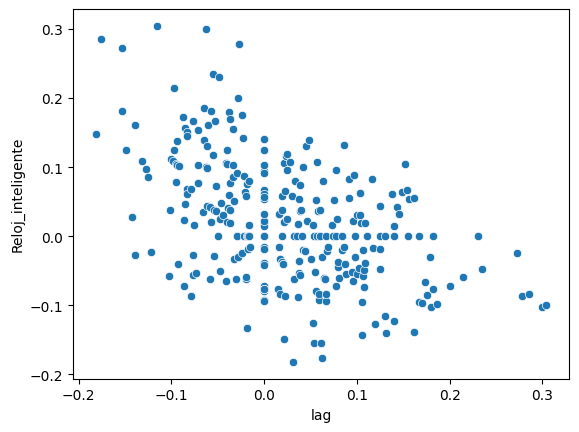

In [ ]:
eval.dropna(inplace=True)
eval = eval.sort_values('lag')
sns.scatterplot(eval,x='lag',y=name)

In [ ]:
x,y = eval[['lag']],eval[name]

Text(0.5, 1.0, 'Modelo Random Forest')

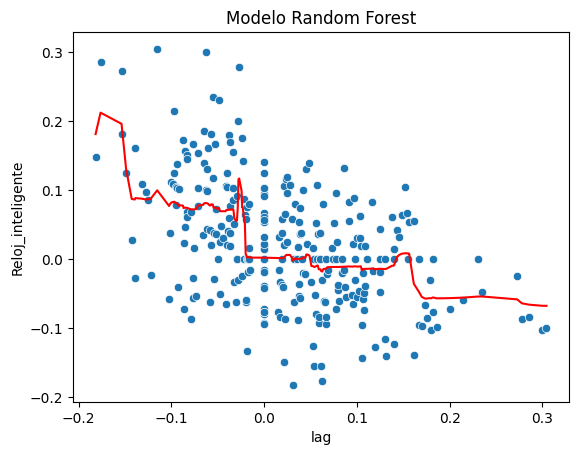

In [ ]:
model = RandomForestRegressor(n_estimators=500, max_depth=3)
model.fit(x,y)
y_pred = model.predict(x)
sns.scatterplot(eval,x='lag',y=name)
plt.plot(x,y_pred,c='red')
plt.title("Modelo Random Forest")

Text(0.5, 1.0, 'Modelo KNN')

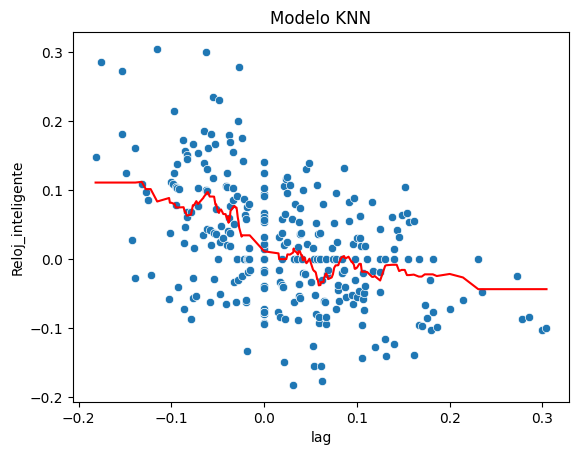

In [ ]:
model = KNeighborsRegressor(n_neighbors=25)
model.fit(x,y)
y_pred = model.predict(x)
sns.scatterplot(eval,x='lag',y=name)
plt.plot(x,y_pred,c='red')
plt.title("Modelo KNN")

In [ ]:
# Distribuciones para búsqueda aleatoria
param_dist = {
    'C': uniform(0.1, 100),          # Valores entre 0.1 y 100
    'epsilon': uniform(0.01, 0.5),   # Valores entre 0.01 y 0.5
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'poly']
}

# Búsqueda aleatoria
model = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Text(0.5, 1.0, 'Modelo SVR')

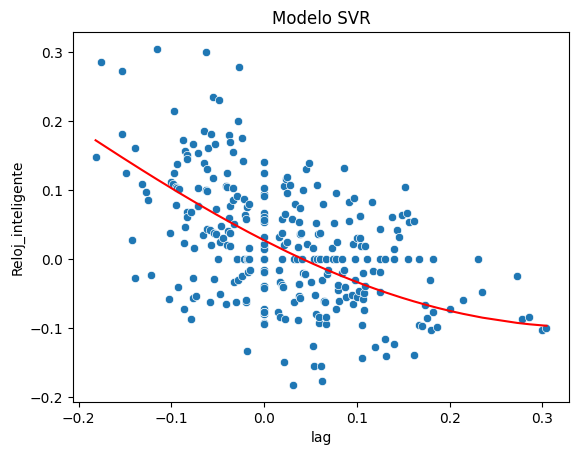

In [ ]:
model.fit(x,y)
y_pred = model.predict(x)
sns.scatterplot(eval,x='lag',y=name)
plt.plot(x,y_pred,c='red')
plt.title("Modelo SVR")

## Funcion

In [ ]:
#serie.reset_index().to_excel("serie.xlsx")

In [ ]:
eval.sort_values('Fecha').head()

,Fecha,Reloj_inteligente,lag
14,2024-01-15,0.214286,-0.096774
15,2024-01-16,0.103448,-0.033333
16,2024-01-17,0.088235,0.096774
17,2024-01-18,-0.030303,0.178571
18,2024-01-19,0.000000,0.066667


In [ ]:
def forecast_ml(tabla, name, lag, step=0, model=None):
  serie = tabla[name]
  crec = serie.pct_change(lag)
  base = crec.reset_index()
  base['original'] = serie.values
  namel = name + str(lag)
  base[namel] = base[name].shift(lag)
  base2 = base.dropna().copy()
  x,y = base2[[namel]],base2[name]
  model.fit(x,y)
  base2['fit_7'] = model.predict(x)
  l_fit = base['original'][lag:(lag*2)].to_list()
  for r in range(len(base2)):
    fit = base2.iloc[r]['fit_7']
    base_ = base.iloc[r+7]['original']
    fit_ = base_*(1+fit)
    l_fit.append(fit_)
  base['fit'] = [0]*lag + l_fit
  if step==0:
    base.index = tabla.index
    return base['fit']
  else:
    l_cambios = base[name].to_list()
    l_fit = base['original'].to_list()
    for t in range(step):
      x_ = l_cambios[-lag]
      df_x_ = pd.DataFrame({namel:[x_]})
      pct_ = model.predict(df_x_)[0]
      fit_ = l_fit[-lag]
      forecast = fit_*(1+pct_)
      l_fit.append(forecast)
      l_cambios.append(pct_)
    start_date = serie.index[-1] + pd.Timedelta(days=1)
    date_range = pd.date_range(start=start_date, periods=step, freq='D')
    new_series = pd.Series(data=l_fit[-step:], index=date_range)
    return new_series

## RandomForest

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=5)

In [ ]:
fit_rf = forecast_ml(tabla, name, 7, model = model)
forecast_rf = forecast_ml(tabla, name, 7, step=n_step, model = model)

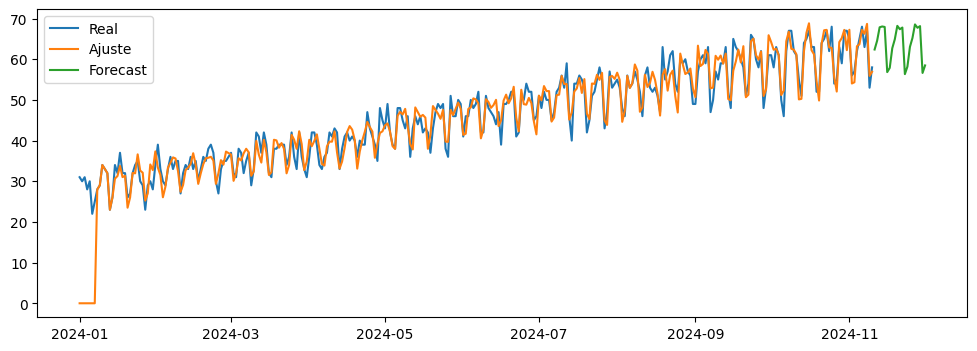

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(tabla[name],label='Real')
ax.plot(fit_rf,label='Ajuste')
ax.plot(forecast_rf,label='Forecast')
ax.legend()
fig.show()

## Knn

In [ ]:
model = KNeighborsRegressor(n_neighbors=20)

In [ ]:
fit_knn = forecast_ml(tabla, name, 7, model = model)
forecast_knn = forecast_ml(tabla, name, 7, step=n_step, model = model)

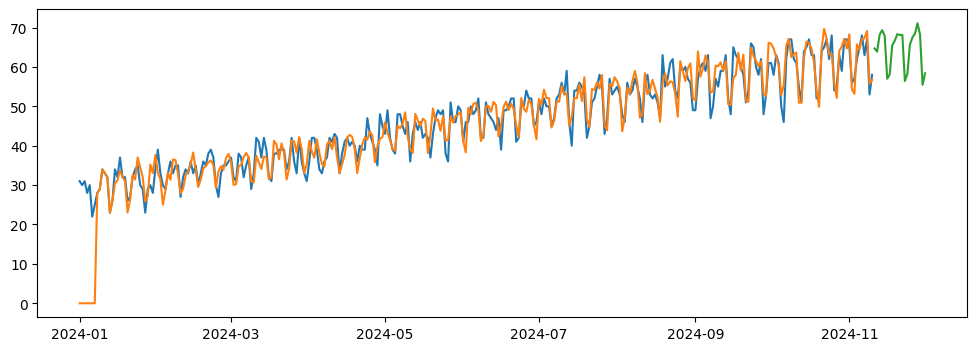

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(tabla[name])
ax.plot(fit_knn)
ax.plot(forecast_knn)
fig.show()

## SVR

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [ ]:
# Distribuciones para búsqueda aleatoria
param_dist = {
    'C': uniform(0.1, 100),          # Valores entre 0.1 y 100
    'epsilon': uniform(0.01, 0.5),   # Valores entre 0.01 y 0.5
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'poly']
}

# Búsqueda aleatoria
model = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=5, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)

In [ ]:
fit_svr = forecast_ml(tabla, name, 7, model = model)
forecast_svr = forecast_ml(tabla, name, 7, step=n_step, model = model)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


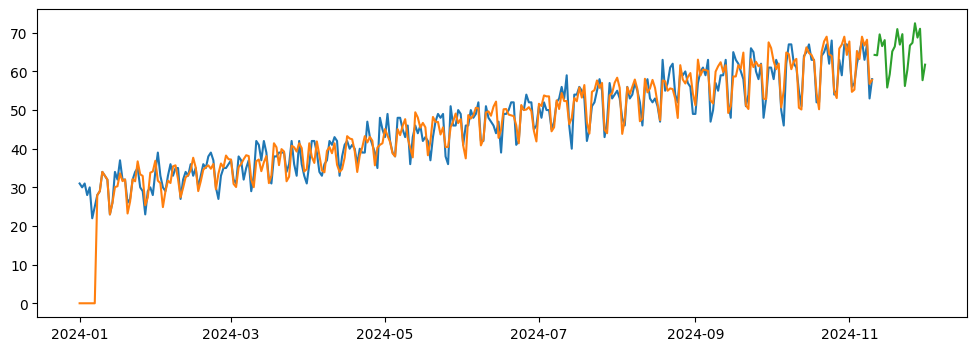

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(tabla[name])
ax.plot(fit_svr)
ax.plot(forecast_svr)
fig.show()

## Comparacion

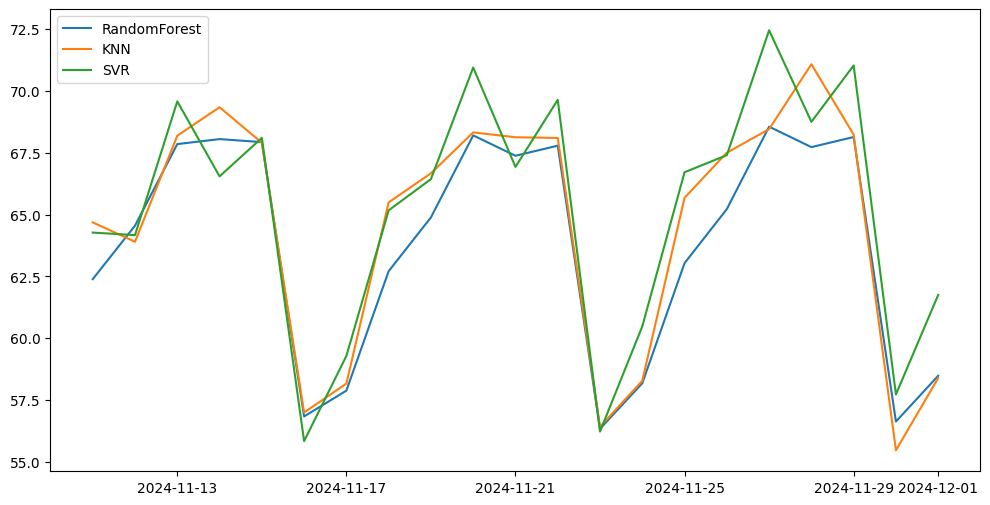

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))

ax.plot(forecast_rf,label="RandomForest")
ax.plot(forecast_knn,label='KNN')
ax.plot(forecast_svr,label='SVR')
ax.legend()
fig.show()